In [8]:
import jupyterthemes
!jt -nf latosans # changement de la police

# Prédire la taille des poissons par régression ?

Les données se trouvent sur Kaggle : https://www.kaggle.com/aungpyaeap/fish-market et ont été mises en ligne par Aung Pyae.

La régression s'inspire en partie de ce que propose de la chaîne YouTube Machine Learnia : https://www.youtube.com/channel/UCmpptkXu8iIFe6kfDK5o7VQ.

# 1. Analyse exploratoire

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import read_csv
import seaborn as sns

### a. Analyse exploratoire des données

In [3]:
df = read_csv("fish.csv")
df.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [4]:
# distributions
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


Coefficient de variation : $c_v = \frac{\sigma}{\mu}$

In [5]:
# coefficient de variation
cv = [round(float(np.std(df[[col]])/np.mean(df[[col]])), 2) for col in df.columns[1:]]

In [6]:
cv

[0.9, 0.38, 0.38, 0.37, 0.48, 0.38]

La masse des individus semble s'annuler, cela témoigne sûrement d'un manque de données. On choisit d'enlever les lignes correspondantes.

In [7]:
df = df.where(df["Weight"] != 0).dropna(axis = 0)

In [8]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,158.000000,158.000000,158.000000,158.000000,158.000000,158.000000
mean,400.847468,26.293038,28.465823,31.280380,8.986790,4.424232
std,357.697796,10.011427,10.731707,11.627605,4.295191,1.689010
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,121.250000,19.150000,21.000000,23.200000,5.940600,3.398650
50%,281.500000,25.300000,27.400000,29.700000,7.789000,4.277050
75%,650.000000,32.700000,35.750000,39.675000,12.371850,5.586750
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


La variable à expliquer est la masse des poissons et les variables explicatives sont leur épaisseur, leur largeur et leurs côtes (les longueurs tête-queue, diagonale et de section).

In [9]:
y = df["Weight"]
m = len(y)

In [10]:
# vers ndarray
y = y.to_numpy().reshape(-1, 1)

In [11]:
species, x1, x2, x3, height, width = df["Species"], df["Length1"], df["Length2"], df["Length3"], df["Height"], df["Width"]

Étudions la distribution des masses en fonction des 3 côtes.

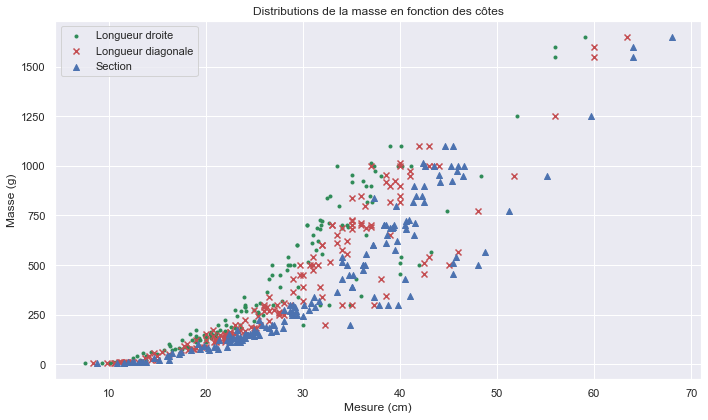

In [12]:
plt.figure(figsize = (10, 6))
sns.set_theme()
plt.scatter(x1, y, c = "seagreen",  marker = ".")
plt.scatter(x2, y, c = "r",  marker = "x")
plt.scatter(x3, y, c = "b",  marker = "^")
plt.title("Distributions de la masse en fonction des côtes")
plt.ylabel("Masse (g)")
plt.xlabel("Mesure (cm)")
plt.legend(["Longueur droite", "Longueur diagonale", "Section"])
plt.tight_layout()

Les distributions semblent corrélées. Par la suite, nous étudierons la matrice de corrélation afin de supprimer les deux dernières côtes.

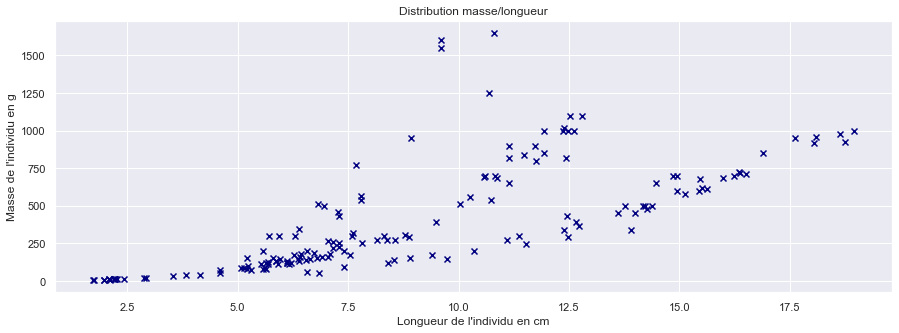

In [13]:
plt.figure(figsize = (15, 5))
plt.title("Distribution masse/longueur")
plt.xlabel("Longueur de l'individu en cm")
plt.ylabel("Masse de l'individu en g")
plt.scatter(height, y, c = 'navy', marker = 'x')

Un modèle polynomial conviendrait sur chacune des trois branches qui apparaissent. <br>
On peut se demander d'où viennent ces tendances bien distinctes. La piste d'espèces différentes est envisageable : il faut alors s'intéresser aux distributions marginales selon les espèces et interpréter les relations de chacune à la variable à expliquer.

In [15]:
species = set(species)
species

{'Bream', 'Parkki', 'Perch', 'Pike', 'Roach', 'Smelt', 'Whitefish'}

Nous allons nous intéresser à la distribution épaisseur/masse pour les poissons appartenant à l'espèce "brème" en particulier.

In [16]:
breams = df.where(df["Species"] == "Bream").dropna(axis = 0).drop(columns = ["Species"])

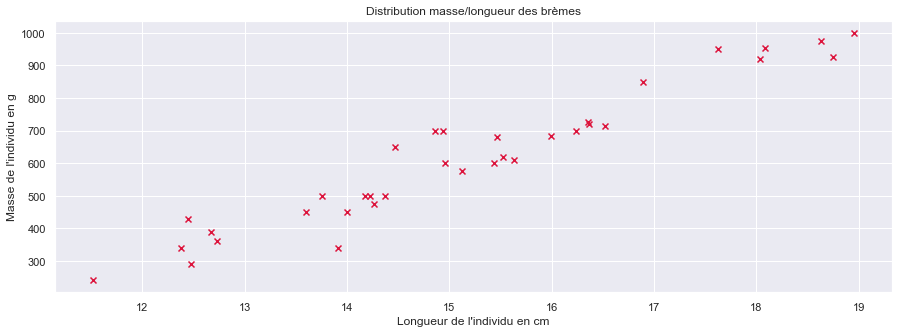

In [18]:
y_bream = breams["Weight"]
height_bream =  breams["Height"]
plt.figure(figsize = (15, 5))
plt.title("Distribution masse/longueur des brèmes")
plt.xlabel("Longueur de l'individu en cm")
plt.ylabel("Masse de l'individu en g")
plt.scatter(height_bream, y_bream, c = 'crimson', marker = 'x')

La relation est cette fois clairement linéaire.

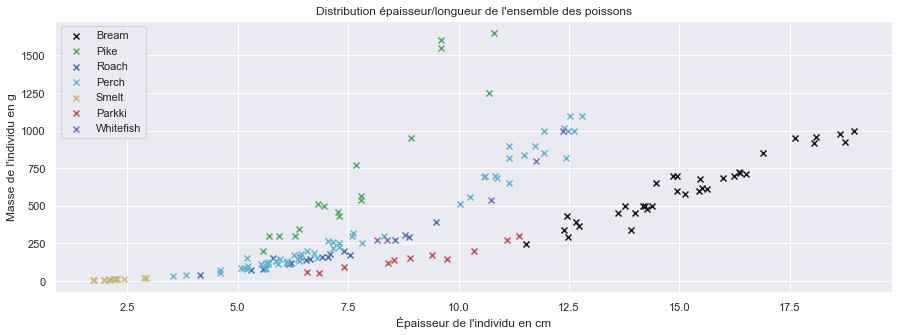

In [14]:
# On peut réitérer l'opération pour chaque espèce
colors = ["k", "g", "b", "c", "y", "r", "m"]
i = 0
plt.figure(figsize = (15, 5))
for spe in species:
    df_spe = df.where(df["Species"] == spe).dropna(axis = 0)
    x_spe, y_spe = df_spe["Height"], df_spe["Weight"]
    plt.scatter(x_spe, y_spe, c = colors[i], marker = "x")
    i += 1
plt.title("Distribution masse/longueur de l'ensemble des poissons")
plt.xlabel("Longueur de l'individu en cm")
plt.ylabel("Masse de l'individu en g")
plt.legend(species)

Il semble que certaines distributions marginales soient linéaires (violet, bleu, rouge...). On peut refaire la même étude sur la dernière feature : la largeur.

Text(0, 0.5, "Masse de l'individu en g")

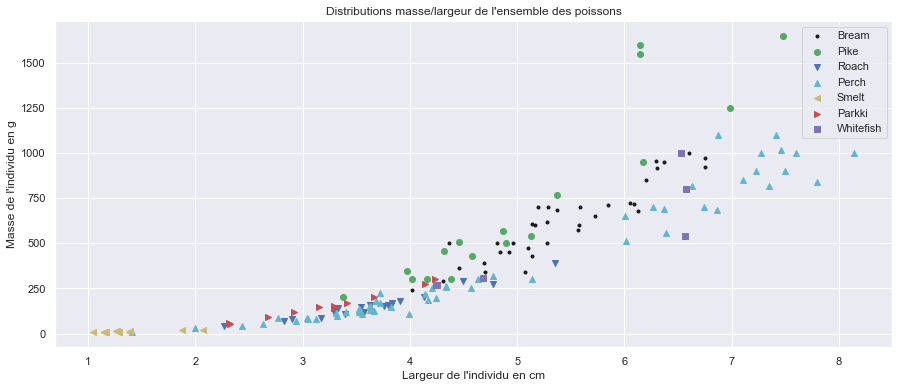

In [15]:
j = 0
plt.figure(figsize = (15, 6))
markers_spe = [".", "o", "v", "^", "<", ">", "s"]
for spe in species:
    df_spe = df.where(df["Species"] == spe).dropna(axis = 0)
    x_spe = df_spe["Width"]
    y_spe = df_spe["Weight"]
    plt.scatter(x_spe, y_spe, c = colors[j], marker = markers_spe[j])
    j += 1
plt.title("Distributions masse/largeur de l'ensemble des poissons")
plt.legend(species)
plt.xlabel("Largeur de l'individu en cm")
plt.ylabel("Masse de l'individu en g")

### b. Étude des corrélations

Text(0.5, 1.0, "Distribution de l'écart absolu entre les features Length1 et 2")

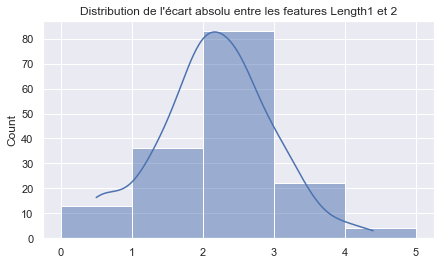

In [19]:
delta = abs(x1 - x2)
plt.figure(figsize = (7, 4))
sns.histplot(delta, bins = range(6), kde = True)
plt.title("Distribution de l'écart absolu entre les features Length1 et 2")

In [20]:
df.corr()

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.915719,0.918603,0.923090,0.723857,0.886654
Length1,0.915719,1.000000,0.999516,0.992004,0.624409,0.866684
Length2,0.918603,0.999516,1.000000,0.994083,0.639503,0.873201
Length3,0.923090,0.992004,0.994083,1.000000,0.702655,0.878189
Height,0.723857,0.624409,0.639503,0.702655,1.000000,0.792401
Width,0.886654,0.866684,0.873201,0.878189,0.792401,1.000000


Les features Length1, Length2 et Length3 sont très corrélées. On supprime les deux derniers.

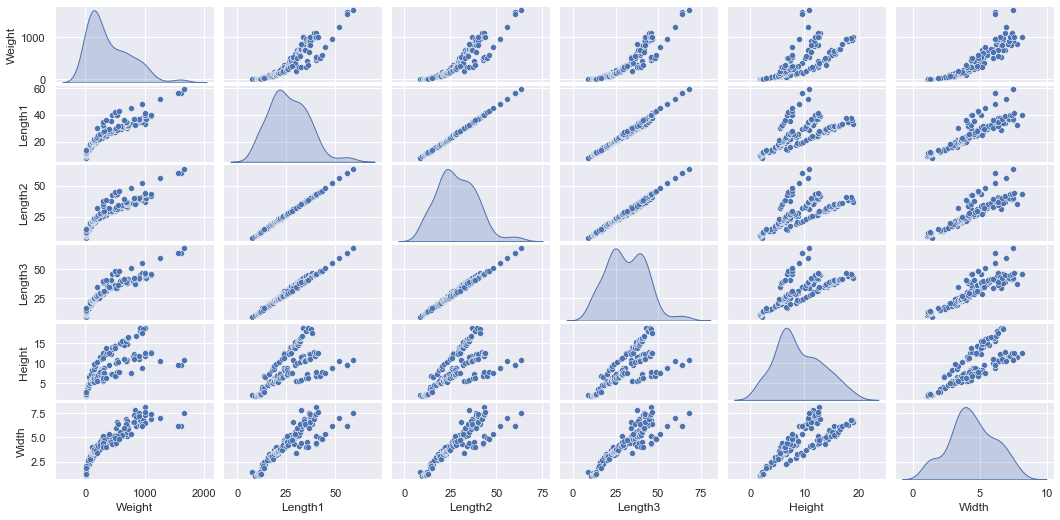

In [32]:
gr = sns.pairplot(df, diag_kind='kde')
gr.fig.set_size_inches(15,7)

In [20]:
df = df.drop(columns = ["Length2", "Length3"])

## 2. Création du modèle linéaire entre la largeur et la masse des poissons
### a. Avec seulement une espèce (brème)

In [21]:
# Définition des jeux de données x et y du modèle : y = f(x)
x = height_bream
y = y_bream
x, y = x.to_numpy().reshape(x.shape[0], 1), y.to_numpy().reshape(y.shape[0], 1)
print(x.shape, y.shape)

(35, 1) (35, 1)


In [22]:
# Création de la matrice X (vecteur x avec une colonne de 1 à droite)
X = np.hstack((x, np.ones(x.shape)))
X.shape

(35, 2)

In [23]:
X

array([[11.52  ,  1.    ],
       [12.48  ,  1.    ],
       [12.3778,  1.    ],
       [12.73  ,  1.    ],
       [12.444 ,  1.    ],
       [13.6024,  1.    ],
       [14.1795,  1.    ],
       [12.67  ,  1.    ],
       [14.0049,  1.    ],
       [14.2266,  1.    ],
       [14.2628,  1.    ],
       [14.3714,  1.    ],
       [13.7592,  1.    ],
       [13.9129,  1.    ],
       [14.9544,  1.    ],
       [15.438 ,  1.    ],
       [14.8604,  1.    ],
       [14.938 ,  1.    ],
       [15.633 ,  1.    ],
       [14.4738,  1.    ],
       [15.1285,  1.    ],
       [15.9936,  1.    ],
       [15.5227,  1.    ],
       [15.4686,  1.    ],
       [16.2405,  1.    ],
       [16.36  ,  1.    ],
       [16.3618,  1.    ],
       [16.517 ,  1.    ],
       [16.8896,  1.    ],
       [18.957 ,  1.    ],
       [18.0369,  1.    ],
       [18.084 ,  1.    ],
       [18.7542,  1.    ],
       [18.6354,  1.    ],
       [17.6235,  1.    ]])

In [24]:
# Initialisation du vecteur de paramètres (a, b) du modèle
theta = np.random.randn(2, 1)
theta

array([[ 0.89759195],
       [-0.45416735]])

In [25]:
# Création du modèle linéaire sous forme matricielle 
def model(X, theta):
    return X.dot(theta)

In [26]:
F = model(X, theta)

In [27]:
# Définition de la fonction de coût : erreur quadratique moyenne
def cost_function(X, y, theta):
    m = len(y)
    return (1/2*m) * np.sum((model(X, theta) - y)**2)

In [28]:
# Définition du gradient de la fonction de coût
def grad(X, y, theta):
    m = len(y)
    return (1/m) * X.T.dot((model(X, theta) - y))

In [29]:
# Définition de l'algorithme de la descente de gradient, que l'on utilisera pour minimiser la fonction de coût selon les paramètres du modèle
def gradient_descent(X, y, theta, learning_rate, n_iterations):
    cost_history = np.zeros(n_iterations)
    for i in range(0, n_iterations):
        theta = theta - learning_rate * grad(X, y, theta)
        cost_history[i] = cost_function(X, y, theta)
    return theta, cost_history

### b. Entraînement

In [30]:
n_it = 25000
theta_final, cost_history = gradient_descent(X, y, theta, learning_rate = 0.008, n_iterations = n_it)
theta_final

array([[ 100.18119175],
       [-902.62305795]])

Text(0, 0.5, 'Masse des individus en g')

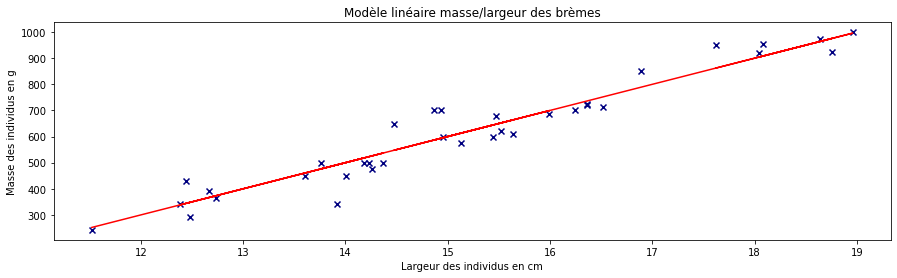

In [31]:
predictions = model(X, theta_final)
plt.figure(figsize = (15, 4))
plt.scatter(x, y, c = "navy", marker = "x")
plt.plot(x, predictions, c = "r")
plt.title("Modèle linéaire masse/largeur des brèmes")
plt.xlabel("Largeur des individus en cm")
plt.ylabel("Masse des individus en g")

Text(0.5, 1.0, 'Fonction de coût au fil des itérations')

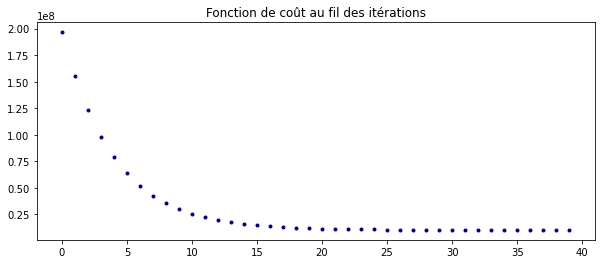

In [32]:
plt.figure(figsize = (10, 4))
plt.scatter(range(40), cost_history[:40], c = "navy", marker = ".")
plt.title("Fonction de coût au fil des itérations")

La décroissance rapide de la fonction de coût sur les premières itérations (facteur 1e8 en ordonnée). La décroissance est linéaire après l'itération 40.

In [33]:
# Définition du coefficient de déterminant R²
def coef_determination(y, pred):
    u = ((y - pred)**2).sum()
    v = ((y - y.mean())**2).sum()
    return round(1 - u/v, 4)

In [34]:
coef_determination(y, predictions)

0.9297

### c. Généralisation à l'ensemble des poissons

In [35]:
x = width
y = df["Weight"]
x, y = x.to_numpy().reshape(x.shape[0], 1), y.to_numpy().reshape(y.shape[0], 1)
print(x.shape, y.shape)

(158, 1) (158, 1)


In [36]:
X = np.hstack((x, np.ones(x.shape)))

In [37]:
theta = np.random.randn(2, 1)

In [38]:
F = model(X, theta)

## d. Entraînement

In [39]:
theta_final, cost_history = gradient_descent(X, y, theta, learning_rate = 0.01, n_iterations = 1000)
theta_final

array([[ 161.3856512 ],
       [-296.97782183]])

Text(0, 0.5, 'Masse des individus en g')

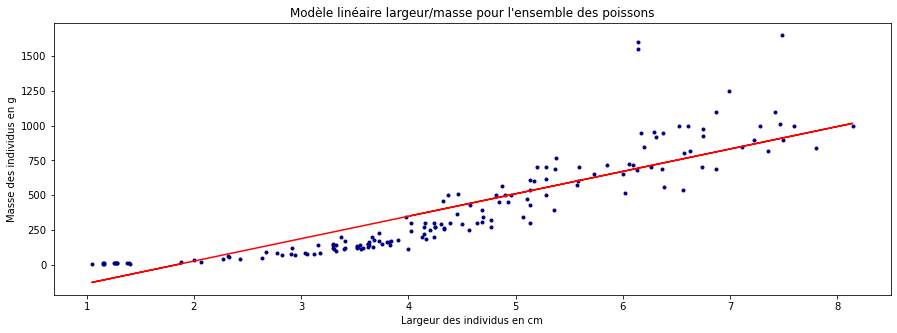

In [40]:
predictions = model(X, theta_final)
plt.figure(figsize = (15, 5))
plt.scatter(x, y, c = 'navy', marker = '.')
plt.plot(x, predictions, c = 'r')
plt.title("Modèle linéaire largeur/masse pour l'ensemble des poissons")
plt.xlabel("Largeur des individus en cm")
plt.ylabel("Masse des individus en g")

Text(0.5, 1.0, 'Fonction de coût au fil des itérations')

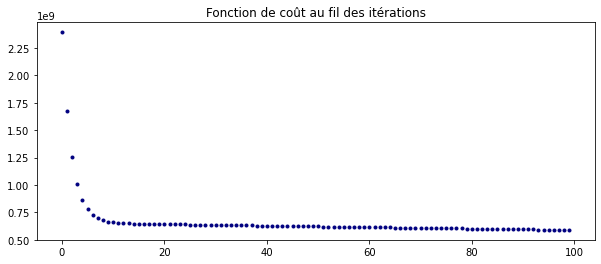

In [41]:
plt.figure(figsize = (10, 4))
plt.scatter(range(100), cost_history[:100], c = "navy", marker = ".")
plt.title("Fonction de coût au fil des itérations")

In [42]:
coef_determination(y, predictions)

0.7686

En conclusion, pour prédire la masse d'un poisson en connaissant la largeur, mieux vaut également connaître son espèce et appliquer un modèle linéaire sur la distribution marginale largeur/masse.

## 3. Vers un modèle polynomial largeur épaisseur pour l'ensemble des poissons

Rien ne change si ce n'est la forme de la matrice X et la taille du vecteur $\theta$ de paramètres. $\newline$
On ajoute une colonne $x^2$ à gauche de X et un paramètre c à $\theta$. Le modèle est $Y = F(X)$ avec $F(X) = X.\theta$ et $\theta = (a, b, c)^T$ $\newline$
On a donc :$ f(x) = ax^2 + bx + c$

In [43]:
X_poly = np.hstack((x**2, X))

In [44]:
# Initialisation du vecteur de paramètres
theta_poly = np.random.randn(3, 1)
theta_poly

array([[0.11205634],
       [0.3982971 ],
       [1.10991044]])

In [45]:
theta_poly_final, cost_history_poly = gradient_descent(X_poly, y, theta_poly, learning_rate = 0.001, n_iterations = 5000)
theta_poly_final

array([[ 23.7943351 ],
       [-24.95305402],
       [-20.55047669]])

Text(0, 0.5, 'Masse des individus en g')

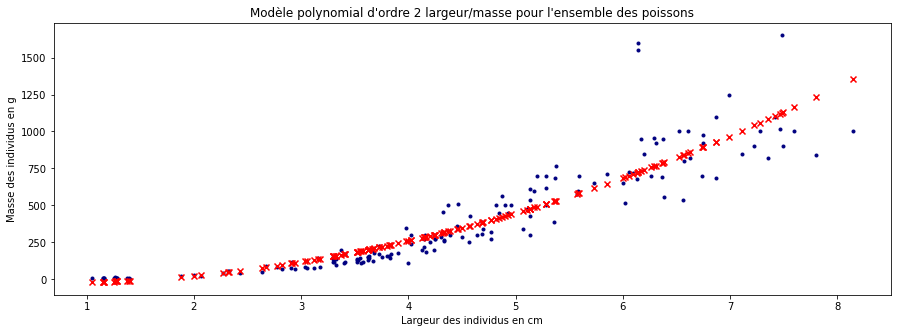

In [46]:
predictions_poly = model(X_poly, theta_poly_final)
plt.figure(figsize = (15, 5))
plt.scatter(x, y, c = 'navy', marker = '.')
plt.scatter(x, predictions_poly, c = 'r', marker = "x")
plt.title("Modèle polynomial d'ordre 2 largeur/masse pour l'ensemble des poissons")
plt.xlabel("Largeur des individus en cm")
plt.ylabel("Masse des individus en g")

Text(0.5, 1.0, 'Fonction de coût au fil des itérations')

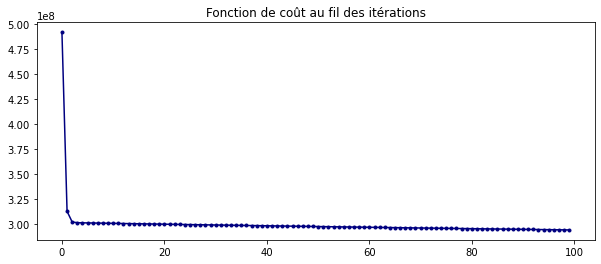

In [47]:
plt.figure(figsize = (10, 4))
plt.plot(range(100), cost_history_poly[:100], c = "navy", marker = ".")
plt.title("Fonction de coût au fil des itérations")

In [48]:
coef_determination(y, predictions_poly)

0.8267

C'est moins bon qu'une régression linéaire sur les distributions marginales.

## 4. Vers un modèle bidimensionnel : régression multiple 

On a maintenant deux features : l'épaisseur et la longueur. On veut les représenter pour voir si une régression multiple pourrait être considérée pour expliquer la variable masse.

In [49]:
x = df[["Height", "Length1"]].to_numpy()

In [50]:
x.shape

(158, 2)

<IPython.core.display.Javascript object>


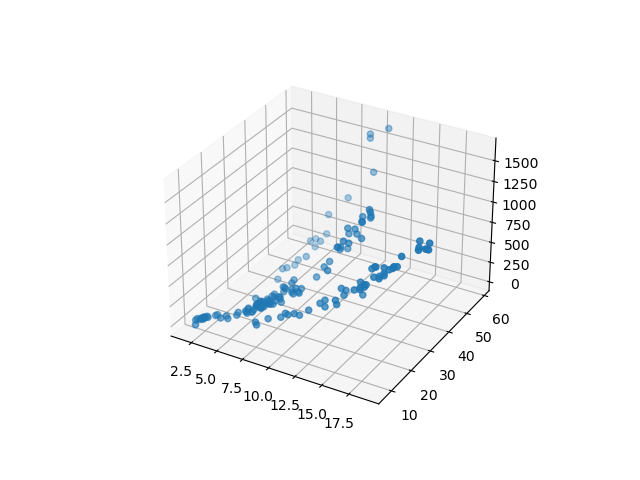

In [63]:
# Distribution 3D de y, x1 et x2
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = "3d")
ax.scatter(x[:, 0], x[:, 1], y)

In [52]:
# Création de la matrice X avec pour colonnes les features "Height" et "Length1" ainsi qu'une colonne de 1
X_mul = np.hstack((x, np.ones((x.shape[0], 1))))

In [53]:
X_mul.shape

(158, 3)

In [54]:
# Initialisation du vecteur de paramètres
theta_mul = np.random.randn(3, 1)

In [55]:
n_it = 10000
theta_mul_final, cost_history_mul = gradient_descent(X_mul, y, theta_mul, learning_rate = 0.002, n_iterations = n_it)
theta_mul_final

array([[  19.81192562],
       [  25.98212871],
       [-454.94294766]])

In [56]:
predictions_mul = model(X_mul, theta_mul_final)

Text(0, 0.5, 'Masse des individus en g')

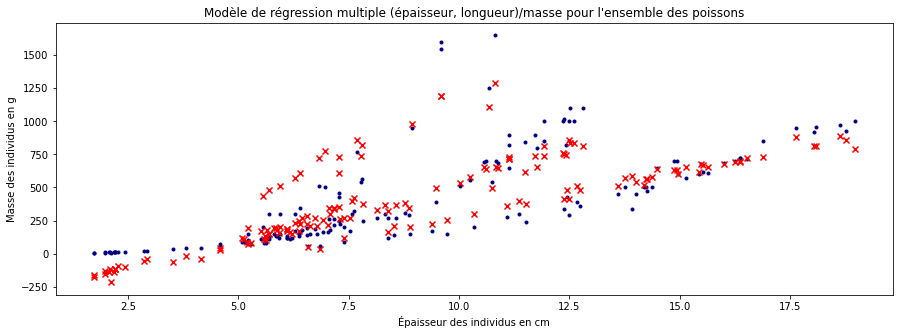

In [57]:
# Distribution de "Height" en fonction de la masse des poissons et prédictions
%matplotlib inline
plt.figure(figsize = (15, 5))
plt.scatter(x[:, 0], y, c = 'navy', marker = '.')
plt.scatter(x[:, 0], predictions_mul, c = 'r', marker = "x")
plt.title("Modèle de régression multiple (épaisseur, longueur)/masse pour l'ensemble des poissons")
plt.xlabel("Épaisseur des individus en cm")
plt.ylabel("Masse des individus en g")

Text(0, 0.5, 'Masse des individus en g')

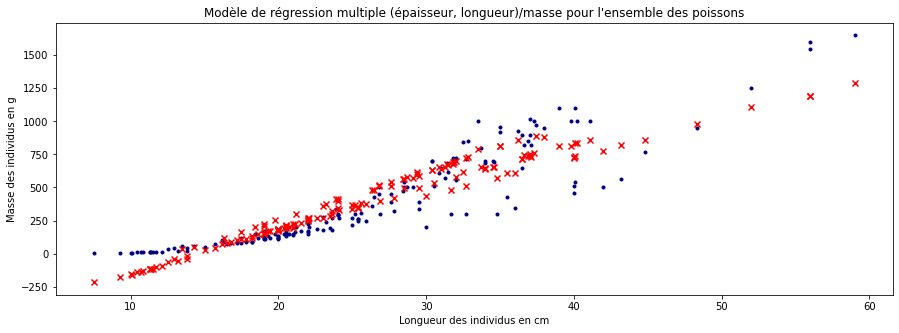

In [58]:
# Distribution de "Length1" en fonction de la masse des poissons et prédictions
plt.figure(figsize = (15, 5))
plt.scatter(x[:, 1], y, c = 'navy', marker = '.')
plt.scatter(x[:, 1], predictions_mul, c = 'r', marker = "x")
plt.title("Modèle de régression multiple (épaisseur, longueur)/masse pour l'ensemble des poissons")
plt.xlabel("Longueur des individus en cm")
plt.ylabel("Masse des individus en g")

<IPython.core.display.Javascript object>


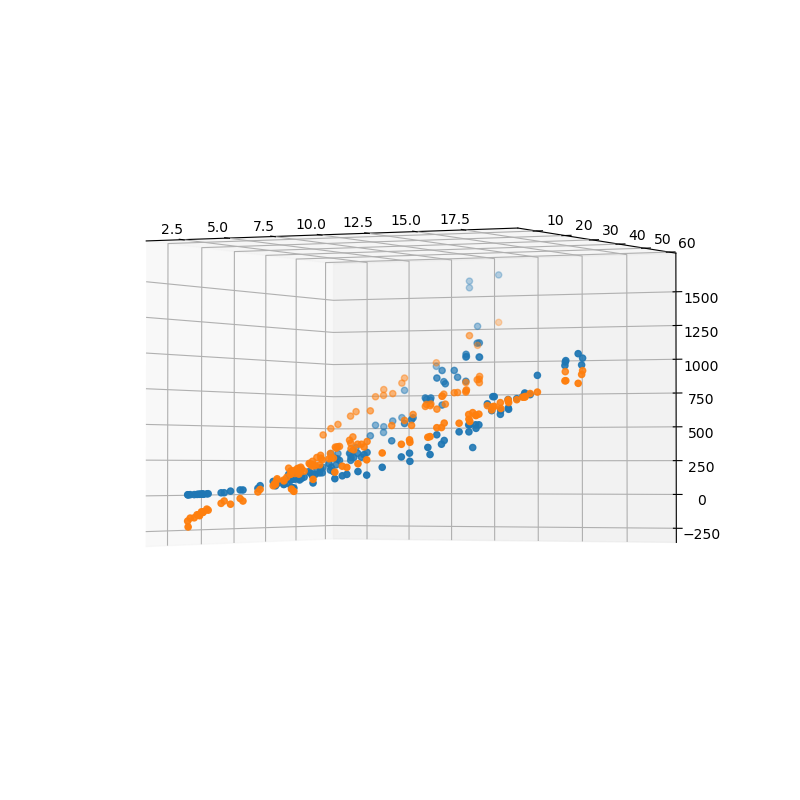

In [67]:
# Visualisation en 3D
%matplotlib notebook
fig_mul = plt.figure(figsize = (8, 8))
ax_mul = fig_mul.add_subplot(111, projection = "3d")
ax_mul.scatter(x[:, 0], x[:, 1], y)
ax_mul.scatter(x[:, 0], x[:, 1], predictions_mul)

Text(0.5, 1.0, 'Fonction de coût au fil des itérations')

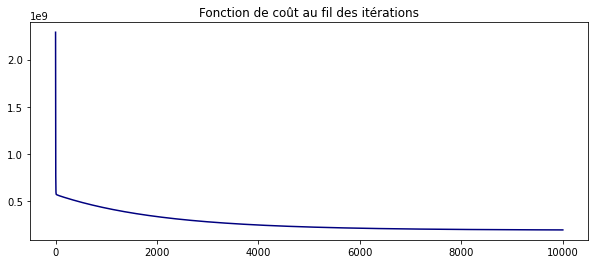

In [60]:
%matplotlib inline
plt.figure(figsize = (10, 4))
plt.plot(range(n_it), cost_history_mul, c = "navy")
plt.title("Fonction de coût au fil des itérations")

In [61]:
coef_determination(y, predictions_mul)

0.8745

En conclusion générale, le modèle le plus adapté est le modèle linéaire (largeur/masse) connaissant l'espèce du poisson. Le modèle de régression en 2 dimensions n'est pas le plus précis.

In [62]:
# Pas mal du tout ! 